In [8]:
import logging
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus, textcorpus
import numpy as np
from gensim.matutils import hellinger
import time
import pickle
import pyLDAvis
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [10]:
# load data
doc_year = [167,196,156,207,249,404,378,
271,
201,
768,
673,
823,
431,
681,
498,
597,
464,
657]

doc_ids =[0]+list(np.cumsum(doc_year))


alldata_new = pickle.load(open('output/20topics_newpreprocess_dict.p', 'rb'))
term_topic = alldata_new['term_topic']# term_topic is n_years*n_topics*n_terms
term_frequency = alldata_new['term_frequency']#term_frequency is n_years*n_terms
terms = alldata_new['terms']#terms is n_terms

doc_topic = []
doc_length=[]
for year in range(len(term_topic)):    
    doc_topic.append(alldata_new['doc_topic'][doc_ids[year]:doc_ids[year+1]])# doc_topic is nyear*n_docs given year*n_topics
    doc_length.append(alldata_new['doc_length'][doc_ids[year]:doc_ids[year+1]]) #doc_length is nyear*n_docs given year
    
# rename topics by their top freq word
topics = range(term_topic.shape[1])

def topic_label(topic, term_topic, terms):
    term_freqs = np.sum(term_topic[:,topic,:], axis = 0)
    max_term = np.argsort(-term_freqs)[0]
    return(terms[max_term])


topic_labels = [topic_label(topic, term_topic, terms) for topic in topics]
import pandas as pd

with open('output/all_visdtm.p','br') as f:
    allvisdtm=pickle.load(f)
for visdtm in allvisdtm:

    visdtm[0]['topiclabel']=topic_labels
topic_labels

['spatial',
 'face',
 'speaker',
 'action',
 'trial',
 'relational',
 'reasoning',
 'probability',
 'stimulus',
 'concept',
 'speech',
 'child',
 'category',
 'rule',
 'sentence',
 'movement',
 'causal',
 'network',
 'student',
 'decision']

[2.9274625603482813, 2.9350817003315082, 2.9079489509712961, 2.9437838096015141, 2.9472592032290175, 2.959251631891147, 2.9610608658604969, 2.9525627522373719, 2.9504945498716473, 2.9619521673246063, 2.951680152357286, 2.9550940150177119, 2.9738169924124125, 2.9569047538413078, 2.9623500912931116, 2.9614276172466001, 2.9606050560772599, 2.9524562313274374]


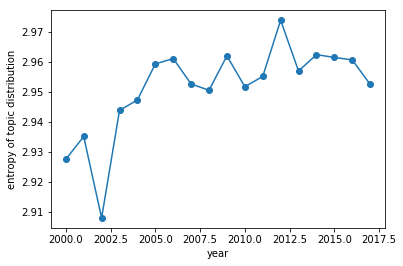

In [17]:
# calculate the topic distribution for each year (should correspond to the topic evolution trend...can't find that code right now)
ntopics = len(topic_labels)
ptop_years = []
entrop_years = []
for iyear in range(len(term_topic)):    
    ptopics = np.zeros(ntopics)
    for doc in doc_topic[iyear]:
        ptopics+=doc
    ptopics = ptopics/sum(ptopics)
    ptop_years.append(ptopics)
    entrop_years.append(entropy(ptopics))
print(entrop_years)

# plot the entropy change across years
years = np.arange(len(term_topic))+2000
plt.plot(years,entrop_years,'-o')
plt.xlabel('year')
plt.ylabel('entropy of topic distribution')
plt.show()

# could be done: find the paper with highest / lowest entropy; find the topic with highest/lowest entropy

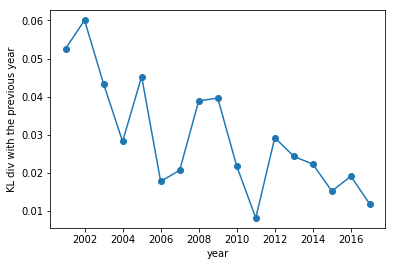

In [21]:
# KL-divergence across years
kl_years = []
for iyear in range(len(term_topic)-1):    
#    kl_years.append(entropy(ptop_years[iyear],ptop_years[iyear+1]))
    kl_years.append(entropy(ptop_years[iyear+1],ptop_years[iyear]))# sanity check: reverse the direction of KL. not differen
plt.plot(years[1:],kl_years,'-o')
plt.xlabel('year')
plt.ylabel('KL div with the previous year')
plt.show()


**tentative conclusion**
- the diversity of topics seem to increase over years
- 2002 has a relatively less diverse topic distribution while 2013 was pretty diverse.

- the year-to-year difference has been decreasing across years...it's like the field is changing more slowly? doesn't make sense to me...